In [ ]:
!pip install pandas numpy sklearn matplotlib tensorly openpyxl

In [254]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF
import tensorly as tl
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor


from sklearn.cluster import KMeans
import scipy.integrate as integrate
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

In [2]:
## Import Data here
X=pd.read_excel('Machine_Learning_tutorials/EMG_daven1.xlsx')
Y=pd.read_excel('Machine_Learning_tutorials/trg.xlsx')
print(X)
print(Y)


In [392]:
##Specify the model rank you want to investigate using this variable throughout
num_components=3

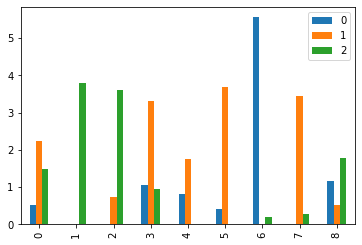

Timepoint specific activation coefficient : [[0.00445753 0.0087293  0.00891719 ... 0.00318417 0.00353221 0.00361545]
 [0.00691987 0.00730602 0.00995962 ... 0.00413595 0.00394586 0.00393877]
 [0.00267341 0.00312425 0.00352195 ... 0.00562449 0.00492552 0.00482269]]


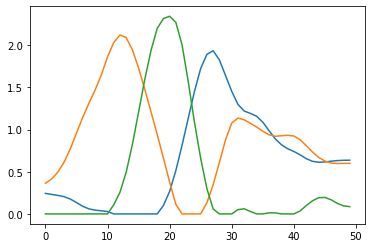

Trial-specific muscle activation coefficient : [[0.09519026 0.01793609 0.01270044 ... 0.02148107 0.00727427 0.00314824]
 [0.05579619 0.02273862 0.07686776 ... 0.04255542 0.00858382 0.01132671]
 [0.09198873 0.01027585 0.03246118 ... 0.03026622 0.0006698  0.01086567]]


In [393]:
##Non-negative matrix factorisation in both the spatial and temporal domains

##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

model=NMF(n_components=num_components, beta_loss='frobenius')


W_spatial = model.fit_transform(abs(X).T)
H_spatial = model.components_

pd.DataFrame(W_spatial).plot(kind='bar')
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)

X_temp=X.values.reshape(640, 50, 9).transpose(1,0,2).reshape(50,640*9)

W_temporal=model.fit_transform(abs(X_temp))
H_temporal = model.components_


plt.plot(W_temporal)
plt.show()
print('Trial-specific muscle activation coefficient :', H_temporal)

Explained variance ratio:  [0.43115244 0.23834114]
Singular values:  [34.23454072 25.45356345]


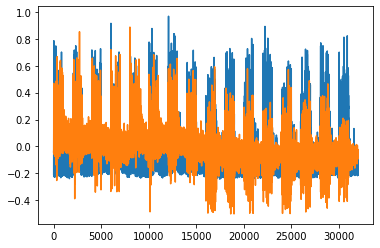

In [152]:
## Principal component analysis
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


model=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model.fit(X)
print('Explained variance ratio: ',model.explained_variance_ratio_)
print('Singular values: ', model.singular_values_)

X_pca=model.transform(X)

plt.plot(X_pca)

Components:  [[ 0.00210996  0.00794264  0.00510211  0.00284798  0.00243836 -0.00504394
   0.02846866 -0.00610419  0.00813373]
 [-0.01227662 -0.00051603 -0.00386599 -0.01853935 -0.01058519 -0.01688371
   0.00858236 -0.01919292 -0.00100488]]
Mixing values:  [[  5.05358624 -10.25645707]
 [  8.262056    -2.28066913]
 [  6.13964153  -4.27486587]
 [  7.28482621 -15.40895576]
 [  4.99185682  -8.98915632]
 [ -1.19361467 -12.23427435]
 [ 27.15686813   0.11856909]
 [ -1.73648179 -13.82034535]
 [  8.57302301  -2.71429235]]
Mean values:  [0.08552499 0.04844104 0.07117152 0.11185034 0.0536936  0.10608485
 0.14986481 0.08273883 0.07012631]


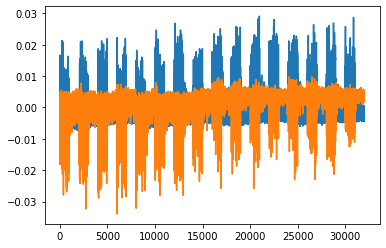

In [10]:
#Independent component analysis
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

model=FastICA(n_components=num_components, algorithm='parallel', whiten=True, 
        fun='logcosh', fun_args=None, max_iter=200, 
        tol=0.0001, w_init=None, random_state=None)
model.fit(X)
print('Components: ',model.components_)
print('Mixing values: ', model.mixing_)
print('Mean values: ', model.mean_)

X_ica=model.transform(X)

plt.plot(X_ica)

Variance accounted for:  0.7598955260111504


<AxesSubplot:>

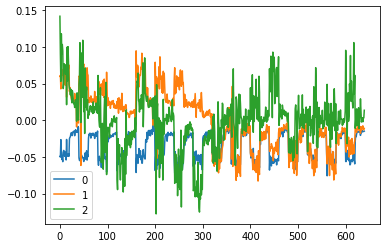

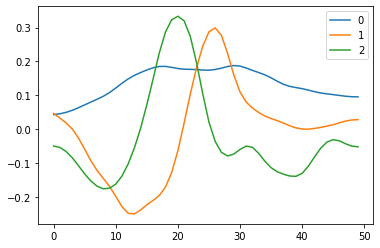

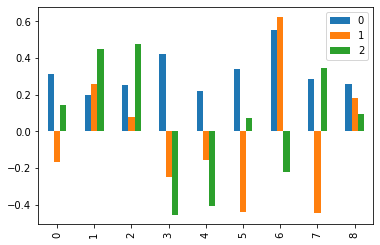

In [394]:
##Tensor decompositions: Tucker-2 decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))

core, factors_tuck = tucker(X_tensor ,rank=[num_components,num_components,num_components])
tucker_recon=tucker_to_tensor([core, factors_tuck])

SSE=np.sum(np.linalg.norm((X_tensor-tucker_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_tuck=1-SSE/SST
print('Variance accounted for: ',VAF_tuck)

pd.DataFrame(factors_tuck[0]).plot()
pd.DataFrame(factors_tuck[1]).plot()
pd.DataFrame(factors_tuck[2]).plot(kind='bar')

Variance accounted for:  0.6649510380241699


<AxesSubplot:>

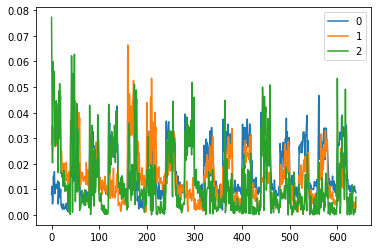

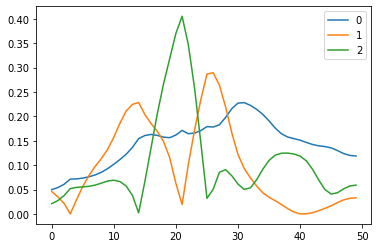

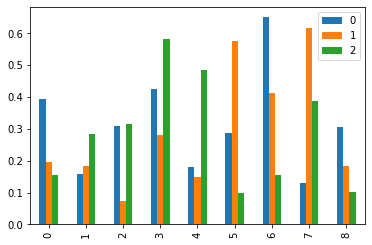

In [395]:
##Tensor decompositions: Non-negative Tucker-2
##http://tensorly.org/stable/user_guide/tensor_decomposition.html
X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))
core, factors_nnt =non_negative_tucker(X_tensor ,rank=[num_components,num_components,num_components])

tucker_recon=tucker_to_tensor([core, factors_nnt])

SSE=np.sum(np.linalg.norm((X_tensor-tucker_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_nnt=1-SSE/SST
print('Variance accounted for: ',VAF_nnt)

pd.DataFrame(factors_nnt[0]).plot()
pd.DataFrame(factors_nnt[1]).plot()
pd.DataFrame(factors_nnt[2]).plot(kind='bar')

Variance accounted for:  0.7491972325204578


<AxesSubplot:>

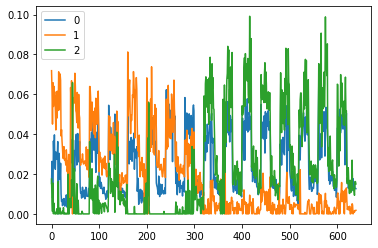

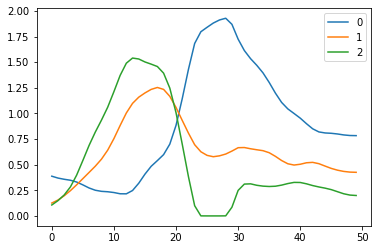

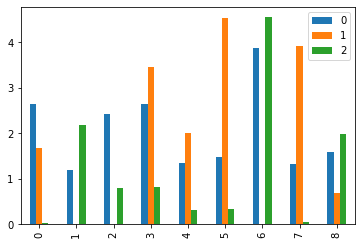

In [396]:
##Tensor decompositions: PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html
X_tensor=tl.tensor(abs(X).values.reshape(640,50,9))
factors_para = non_negative_parafac(X_tensor ,rank=num_components)
parafac_recon=tl.cp_to_tensor(factors_para)
SSE=np.sum(np.linalg.norm((X_tensor-parafac_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_para=1-SSE/SST
print('Variance accounted for: ',VAF_para)

pd.DataFrame(factors_para[1][0]).plot()
pd.DataFrame(factors_para[1][1]).plot()
pd.DataFrame(factors_para[1][2]).plot(kind='bar')

In [259]:
## Decode the task using the underlying parameters trial-specific coefficients from the above tensor decompositions
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008



LDA Accuracy score:  0.5416666666666666


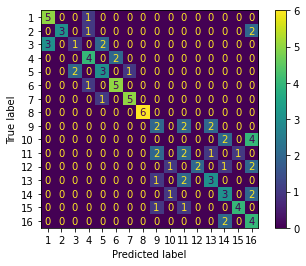

Naive Bayes Accuracy score:  0.59375


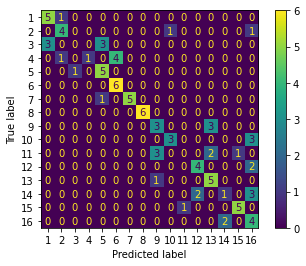

K-Nearest Neighbors Accuracy score:  0.5729166666666666


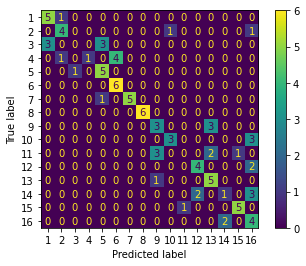

In [397]:
#Tucker decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],Y.iloc[:,0].values,train_size=0.85,stratify=Y.iloc[:,0].values)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_tuck=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()

LDA Accuracy score:  0.4583333333333333


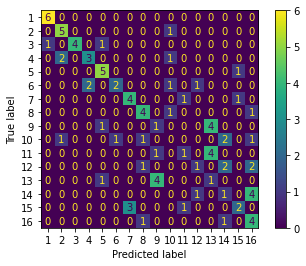

Naive Bayes Accuracy score:  0.4791666666666667


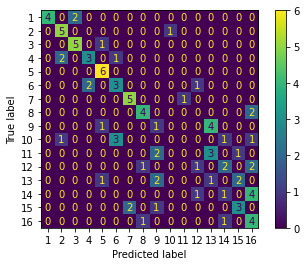

K-Nearest Neighbors Accuracy score:  0.4479166666666667


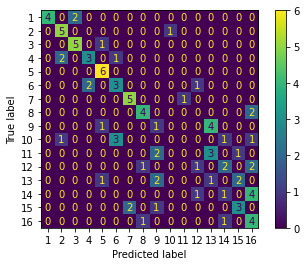

In [398]:
##Non-negative Tucker decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_nnt[0],Y.iloc[:,0].values,train_size=0.85,stratify=Y.iloc[:,0].values)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_nnt=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()

LDA Accuracy score:  0.5520833333333334


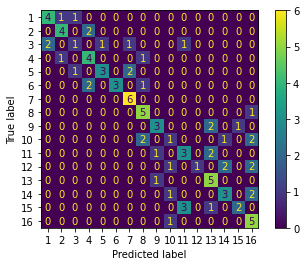

Naive Bayes Accuracy score:  0.46875


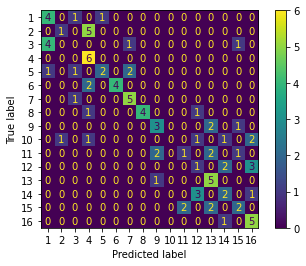

K-Nearest Neighbors Accuracy score:  0.5729166666666666


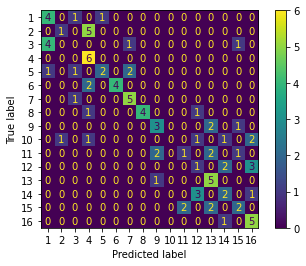

In [399]:
##Parafac-decomposition
X_train, X_test, y_train, y_test=train_test_split(factors_para[1][0],Y.iloc[:,0].values,train_size=0.85,stratify=Y.iloc[:,0].values)

model=LDA()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_para=accuracy_score(y_test,y_pred)
plot_confusion_matrix(model,X_test,y_test)
plt.show()

#Naive-Bayes
#https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print('Naive Bayes Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()


##K-Nearest Neighbors
##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
knn=KNN(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('K-Nearest Neighbors Accuracy score: ',accuracy_score(y_test,y_pred))
plot_confusion_matrix(gnb ,X_test,y_test)
plt.show()

In [400]:
##Can you find the model that gives the best output in terms of the VAF vs Task-decoding trade-off??
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008

print('Tucker decomposition: ', VAF_tuck*LDA_acc_tuck)
print('Non-negative Tucker decomposition: ', VAF_nnt*LDA_acc_nnt)
print('PARAFAC decomposition: ', VAF_para*LDA_acc_para)

Tucker decomposition:  0.4116100765893731
Non-negative Tucker decomposition:  0.30476922576107784
PARAFAC decomposition:  0.4136193054540028
